In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.signal as signal
import numpy as np
import astropy.constants as const
import astropy.units as u
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)
from scipy.optimize import minimize, curve_fit

Laboratorio 1 Electricidad y Magnetismo

In [2]:
err_medicion = 0.5 * u.mm
err_fuente = 0.1 * u.kV

In [3]:
distancia_placas = 3 * u.mm
densidad_ricino = 960 * (u.kg / u.m**3)
densidad_silicona = 970 * (u.kg / u.m**3)
permitividad_vacio_si = const.eps0.to((u.A ** 2 * u.s** 4) / (u.kg * u.m**3))

In [4]:
datos_raw = pd.read_csv('datos_vya.csv', sep='\t')
datos_voltajes_alturas = pd.DataFrame()
for key in datos_raw.keys():
    if key.startswith("Unnamed"):
        continue
    else:
        datos_voltajes_alturas[key] = datos_raw[key]

list_err_kV = list()
list_err_mm = list()
list_err_V = list()
list_err_m = list()

for i in range(len(datos_voltajes_alturas["Voltajes_R"])):
    list_err_kV.append(err_fuente.value)
    list_err_mm.append(err_medicion.value)

    list_err_V.append(err_fuente.to(u.V).value)
    list_err_m.append(err_medicion.to(u.m).value)

datos_voltajes_alturas["Err_mm"] = list_err_mm
datos_voltajes_alturas["Err_kV"] = list_err_kV

datos_voltajes_alturas

,Voltajes_R,Alturas_R,Voltajes_S,Alturas_S,Err_mm,Err_kV
0,0.0,0.0,0.0,0.0,0.5,0.1
1,1.0,0.1,1.0,0.1,0.5,0.1
2,2.0,0.5,1.2,0.2,0.5,0.1
3,3.0,1.2,1.4,0.2,0.5,0.1
4,4.0,2.0,1.6,0.2,0.5,0.1
5,5.0,3.5,1.8,0.3,0.5,0.1
6,1.2,0.2,2.0,0.5,0.5,0.1
7,1.4,0.3,2.2,0.5,0.5,0.1
8,1.6,0.3,2.4,0.6,0.5,0.1
9,1.8,0.4,2.6,0.7,0.5,0.1


In [5]:
voltajes_ricino = datos_voltajes_alturas['Voltajes_R']
alturas_ricino = datos_voltajes_alturas['Alturas_R']

voltajes_silicona = datos_voltajes_alturas['Voltajes_S']
alturas_silicona = datos_voltajes_alturas['Alturas_S']

lista_voltajes_ricino = sorted([(volt*1000)**2 for volt in voltajes_ricino])
lista_voltajes_ricino_kv = sorted([(volt)**2 for volt in voltajes_ricino])
lista_alturas_ricino = sorted([((alt * u.mm).to(u.m)).value for alt in alturas_ricino])
lista_alturas_ricino_mm = sorted([alt for alt in alturas_ricino])

lista_voltajes_silicona = sorted([(volt*1000)**2 for volt in voltajes_silicona[:10]])
lista_voltajes_silicona_kv = sorted([(volt)**2 for volt in voltajes_silicona[:10]])
lista_alturas_silicona = sorted([((alt * u.mm).to(u.m)).value for alt in alturas_silicona[:10]])
lista_alturas_silicona_mm = sorted([alt for alt in alturas_silicona[:10]])

err_alturas_ricino = [err / 1000 for err in list_err_mm]



## Aceite de Ricino

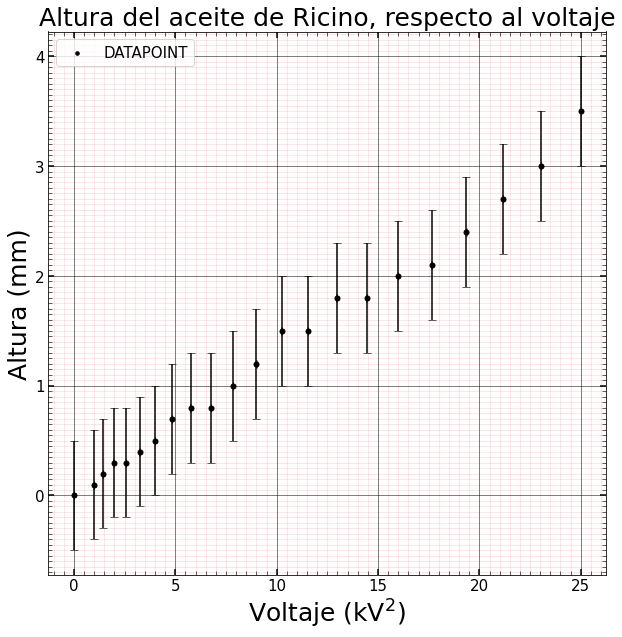

In [6]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.errorbar(lista_voltajes_ricino_kv, lista_alturas_ricino_mm, xerr = datos_voltajes_alturas["Err_kV"] ** 2, yerr = datos_voltajes_alturas["Err_mm"],
             fmt = '.', markersize = '10', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6 )
ax1.scatter(lista_voltajes_ricino_kv, lista_alturas_ricino_mm, marker=".", s=50, c="black", label='DATAPOINT')
ax1.set_title('Altura del aceite de Ricino, respecto al voltaje', fontsize=25)
ax1.set_ylabel('Altura (mm)', fontsize=25)
ax1.set_xlabel(r'Voltaje (kV$^2$)', fontsize=25)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

In [7]:
def modelo_altura_dielectrico_ricino(voltaje,
                              constante_dielectrica):
    
    aux_top_frac = permitividad_vacio_si * (constante_dielectrica - 1)
    aux_bottom_frac = densidad_ricino * const.g0 * (distancia_placas.to(u.m) ** 2)
    return (((aux_top_frac / (aux_bottom_frac)).value * ((voltaje))))

In [8]:
popt_ricino, pcov_ricino = curve_fit(modelo_altura_dielectrico_ricino, lista_voltajes_ricino, lista_alturas_ricino)
print(f"Ajuste ricino: {popt_ricino[0]}")

Ajuste ricino: 2.2453565672014295


In [9]:
aux_lista_densidad_ricino = [densidad_ricino.value for i in range(len(lista_voltajes_ricino))]
aux_lista_ajuste_ricino = [popt_ricino[0] for i in range(len(lista_voltajes_ricino))]


def err_constante_dielectrica(voltaje, cte_dielectrica, densidad, err_altura, err_voltaje, err_distancia):
    err_altura_total = err_altura
    err_voltaje_total = 2 * ((permitividad_vacio_si.value * (cte_dielectrica - 1))/(densidad * const.g0.value * (distancia_placas.to(u.m).value ** 2))) * np.sqrt(voltaje) * err_voltaje
    err_distancia_total = -2 * ((permitividad_vacio_si.value * (cte_dielectrica - 1))/(densidad * const.g0.value * (distancia_placas.to(u.m).value ** 2))) * voltaje * err_distancia
    err_sqrt = np.sqrt((err_altura_total ** 2) - (err_voltaje_total ** 2) - (err_distancia_total ** 2)) 
    return (err_sqrt * densidad * const.g0.value * (distancia_placas.to(u.m).value ** 2))/(voltaje * permitividad_vacio_si.value)

list_err_constante_dielectrica_ricino = err_constante_dielectrica(pd.DataFrame(lista_voltajes_ricino), 
                                                                  pd.DataFrame(aux_lista_ajuste_ricino),
                                                                  pd.DataFrame(aux_lista_densidad_ricino),
                                                                  pd.DataFrame(list_err_m),
                                                                  pd.DataFrame(list_err_V),
                                                                  pd.DataFrame(list_err_m))
perr_ricino = np.mean(list_err_constante_dielectrica_ricino[1:])[0]
print(f"Error ajuste ricino: ± {perr_ricino}")

Error ajuste ricino: ± 1.0307954704957356


c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [10]:
voltajes_linspace_ricino = np.linspace(0, 5000**2, 50)

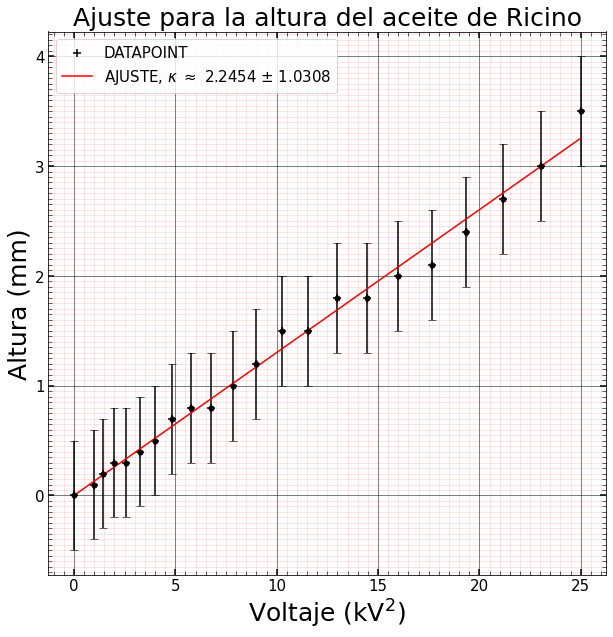

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.errorbar(lista_voltajes_ricino_kv, lista_alturas_ricino_mm, xerr = datos_voltajes_alturas["Err_kV"] ** 2, yerr = datos_voltajes_alturas["Err_mm"],
             fmt = '.', markersize = '10', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6 )
ax1.scatter(lista_voltajes_ricino_kv, lista_alturas_ricino_mm, marker="+", s=50, c="black", label='DATAPOINT')
ax1.plot(voltajes_linspace_ricino/1000000, modelo_altura_dielectrico_ricino(voltajes_linspace_ricino, popt_ricino[0])*1000, c="red",
         label=r'AJUSTE, $\kappa$ $\approx$ {} ± {}'.format(round(popt_ricino[0], 4), round(perr_ricino, 4)))
ax1.set_title('Ajuste para la altura del aceite de Ricino', fontsize=25)
ax1.set_ylabel('Altura (mm)', fontsize=25)
ax1.set_xlabel(r'Voltaje (kV$^2$)', fontsize=25)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

## Silicona

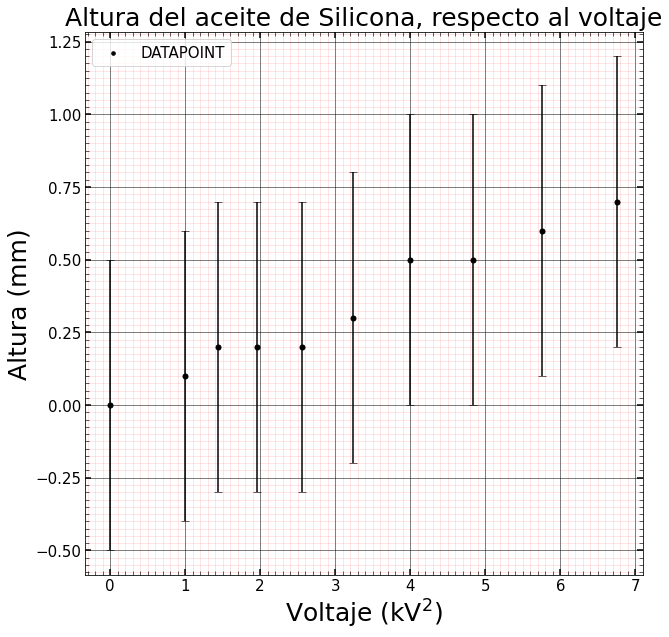

In [12]:
lista_err_altura_silicona = [err_medicion.value for i in range(len(lista_alturas_silicona))]

fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.errorbar(lista_voltajes_silicona_kv, lista_alturas_silicona_mm, yerr = lista_err_altura_silicona,
             fmt = '.', markersize = '10', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6 )
ax1.scatter(lista_voltajes_silicona_kv, lista_alturas_silicona_mm, marker=".", s=50, c="black", label='DATAPOINT')
ax1.set_title('Altura del aceite de Silicona, respecto al voltaje', fontsize=25)
ax1.set_ylabel('Altura (mm)', fontsize=25)
ax1.set_xlabel(r'Voltaje (kV$^2$)', fontsize=25)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.025))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

In [13]:
def modelo_altura_dielectrico_silicona(voltaje,
                              constante_dielectrica):
    
    aux_top_frac = permitividad_vacio_si * (constante_dielectrica - 1)
    aux_bottom_frac = densidad_silicona * const.g0 * (distancia_placas.to(u.m) ** 2)
    return (((aux_top_frac / (aux_bottom_frac)).value * ((voltaje))))

In [14]:
popt_silicona, pcov_silicona = curve_fit(modelo_altura_dielectrico_silicona, lista_voltajes_silicona, lista_alturas_silicona)
popt_silicona[0]

2.0107663660134087

In [15]:
aux_lista_densidad_silicona = [densidad_silicona.value for i in range(len(lista_voltajes_silicona))]
aux_lista_ajuste_silicona = [popt_silicona[0] for i in range(len(lista_voltajes_silicona))]

list_err_constante_dielectrica_silicona = err_constante_dielectrica(pd.DataFrame(lista_voltajes_silicona), 
                                                                  pd.DataFrame(aux_lista_ajuste_silicona),
                                                                  pd.DataFrame(aux_lista_densidad_silicona),
                                                                  pd.DataFrame(list_err_m[0:len(lista_voltajes_silicona)]),
                                                                  pd.DataFrame(list_err_V[0:len(lista_voltajes_silicona)]),
                                                                  pd.DataFrame(list_err_m[0:len(lista_voltajes_silicona)]))
perr_silicona = np.mean(list_err_constante_dielectrica_silicona[1:])[0]
print(f"Error ajuste silicona: ± {perr_silicona}")

Error ajuste silicona: ± 1.973671511949259


c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [16]:
voltajes_linspace_silicona = np.linspace(0, 2600**2, 50)

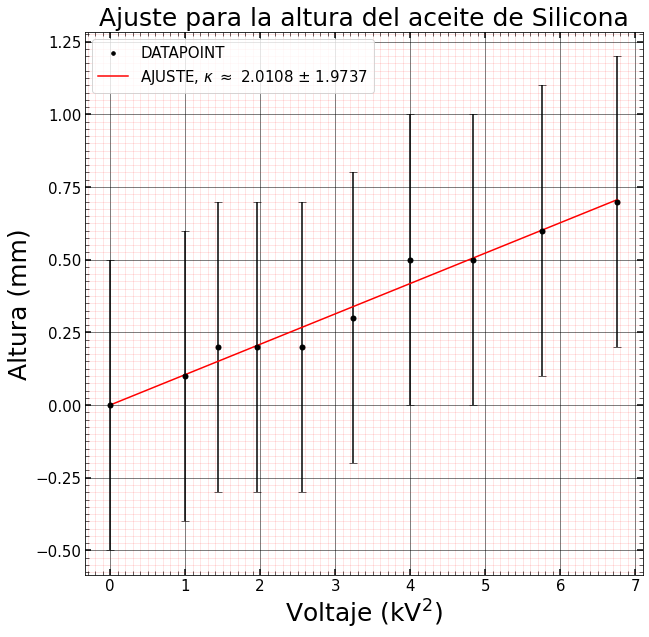

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.errorbar(lista_voltajes_silicona_kv, lista_alturas_silicona_mm, yerr = lista_err_altura_silicona,
             fmt = '.', markersize = '10', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6 )
ax1.scatter(lista_voltajes_silicona_kv, lista_alturas_silicona_mm, marker=".", s=50, c="black", label='DATAPOINT')
ax1.plot(voltajes_linspace_silicona/1000000, modelo_altura_dielectrico_silicona(voltajes_linspace_silicona, popt_silicona[0])*1000, c="red",
         label=r'AJUSTE, $\kappa$ $\approx$ {} ± {}'.format(round(popt_silicona[0], 4), round(perr_silicona, 4)))
ax1.set_title('Ajuste para la altura del aceite de Silicona', fontsize=25)
ax1.set_ylabel('Altura (mm)', fontsize=25)
ax1.set_xlabel(r'Voltaje (kV$^2$)', fontsize=25)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.025))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)